## Sequence-to-sequence layers

At the heart of self-attention are sequence-to-sequence layers, or layers which take as an input a sequence of tensors and provide an output sequence of tensors of the same length. 

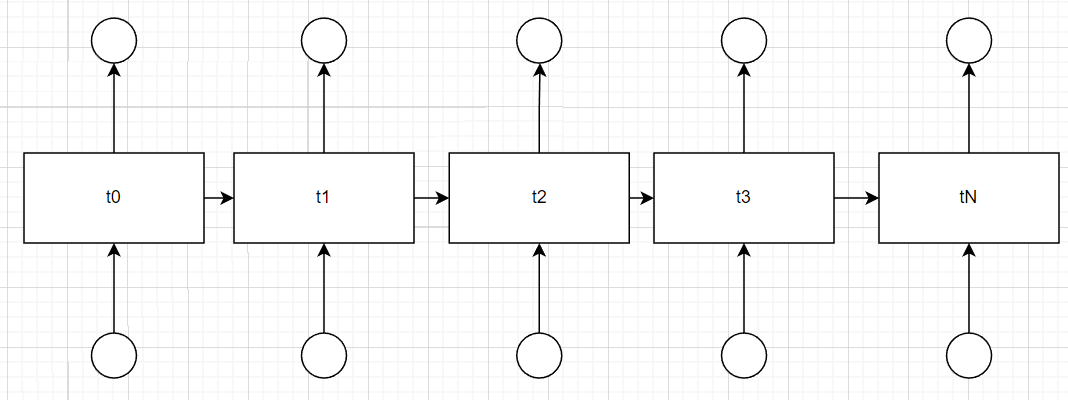

Sequence-to-sequence layers were originally implemented using RNNs ((Cho et al., 2014a) and (Sutskever et al., 2014)), where embedding is used to generate a sequence of vectors which are fed into the RNN network. The encoder portion produces a final latent variable that is then fed into a decoder RNN to produce the output sequence.  

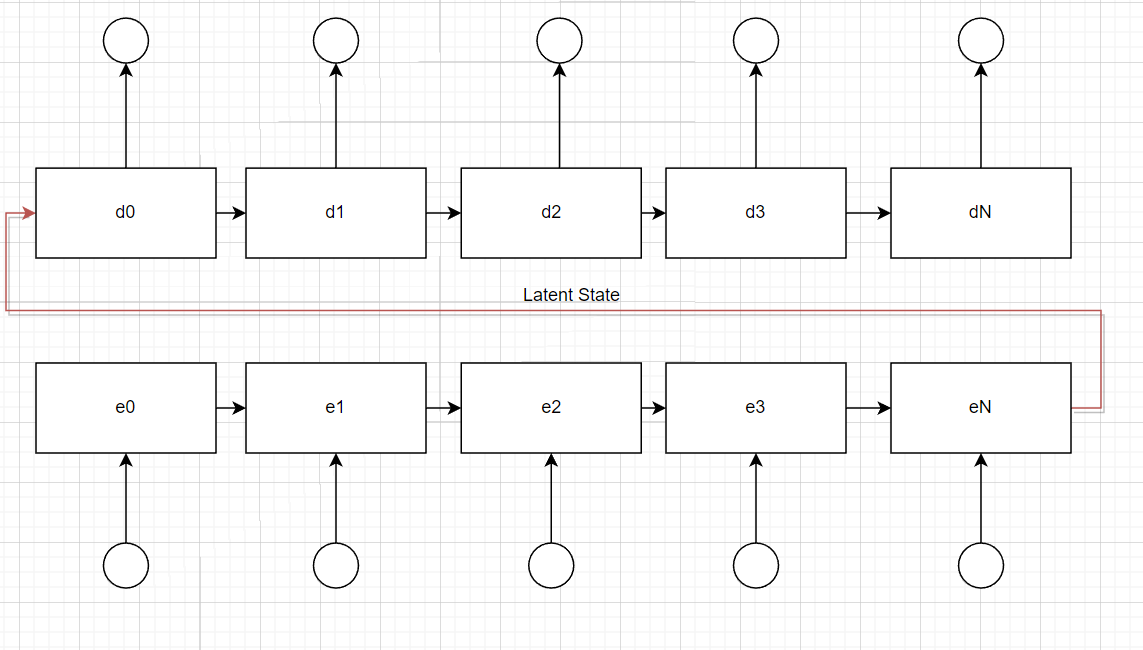

The problem with RNNs is the latent variable being passed around has a limited capacity to properly encode long sequences, and so quality drops off as the input sequence grows in length. This is analogous to a human translator needing to wait for the completion of an entire speech before accurately translating it. Additionally, RNNs are impossible to parallelize due to their recurrent nature. 

CNNs were also introduced as another means of taking an input sequence and producing an output sequence. They can be more easily parallelized and can extend themselves beyond a single latent variable, but relating information between two distant elements of a series requires increasingly more operations (linear for ConvS2S, and logarithmic for ByteNet). 

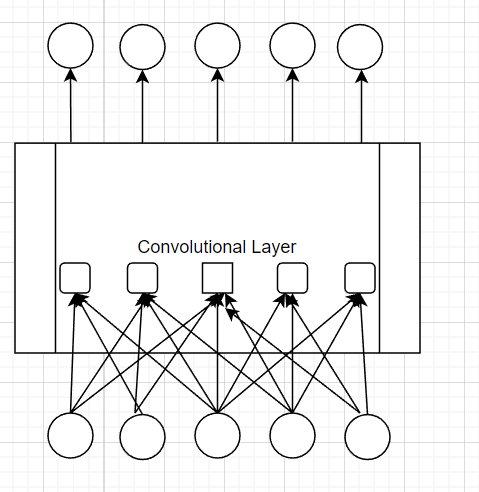

There was therefore a need to provide increased parallelizability in addition to maintaining the ability for information in one element of a sequence to be combined with that of a distant other.  

## Attention

https://arxiv.org/abs/1409.0473 (Neural Machine Translation by Jointly Learning to Align and Translate)

Attention was first introduced in the seminal work "Neural Machine Translation by Jointly Learning to Align and Translate". The main idea is that the encoder becomes a bi-directional RNN while the decoder is a forward-only RNN that sources not only from previous states through a latent variable, but also a context generated by the each of the encoder outputs, weighted by relevance.  

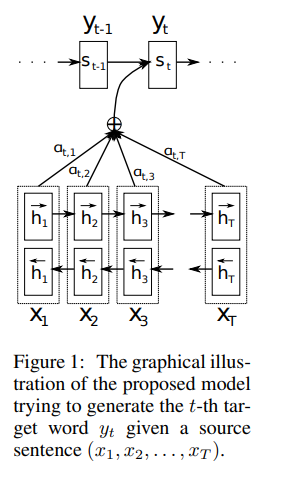

There are two crucial concepts to take away here: the first is that of the context. The context for output element $i$ of the output sequence is defined as: 

$ c_i = \sum_{j=1}^{T_x} a_{ij} h_j  $

So the context being fed to the decoder at a certain step is the weighted sum of all the outputs of the encoder. The weights are softmaxed so they are all positive and sum to 1. 

The second important point to make is that the weights $ a $ are determined by a feedforward neural network co-trained with the rest of the system. The result of this is that different parts of the input sequence are determined to be more important than others, and that the system to determine that is trained by back prop. The paper refers to this as an *alignment model*. 

## Scaled Dot-Production Attention

In the paper _Neural Machine Translation by Jointly Learning to Align and Translate_ the alignment model was a single-layer, feed-forward neural network that was trained alongside the rest of the model. Its purpose was to score how well inputs $ j $ relate to outputs $ i $ to produce the weighting coefficients. Since that paper, another alignment model has become more commonly used: the dot product itself. 

Due to its computational simplicity, lower memory footprint, and ability to measure similarity over an embedding space, the dot product is an ideal replacement for the feed-forward network used in the previous paper. In the paper _Attention Is All You Need_ the authors propose a scaled dot-product attention mechanism. 

Given a set of input embedding vectors $ X $, the task is still to produce output vectors as a weighted some of the input vectors. 

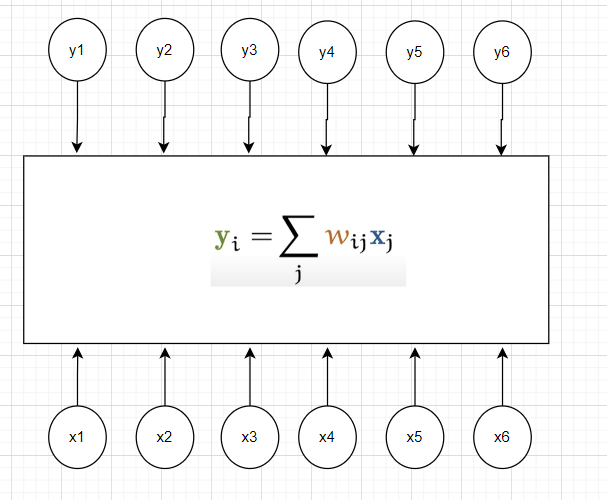

As an example, to compute the 3rd output of the sequence ($ y_3 $), the operation becomes: 

$ y_3 = \sum_{j=1}^{6} w_{3j} x_j  $ 

The weight matrix $ w $ is the dot product of the vector $ x_3 $ with each other input vector, with a row-wise softmax operation. The result scales each vector $ x_j $ by its relevance to $ x_3 $. 

Stepping back for a moment: if our embedding scheme has done a good job, it has created a decent-enough word embedding where the dot product can be seen as measuring a meaningful similarity between the elements. We can then begin to form a vague notion that the resultant output vector at time $ t $ is the result of input vectors weighted by how impactful each is to the final result. While no parameters are learnable (yet), we can see how the information about relevance is maintained. 


### Keys, values and queries

The paper takes a turn and starts to refer to the input vectors as keys, values and queries depending on how they're used. This actually makes things a bit confusing. I believe one major driver is because when learnable matrices are introduced, the identities of the inputs change slightly as the values are dotted with learnable matrices their values change. Also, the authors see the following operations as akin to database lookups (so the terms keys, values and queries apply in their mind). 

For example, vector $ x3 $ above is identified as a _value_, each time the value is dotted with another embedding vector, it is referred to as a _query_. Each embedded vector it is dotted with becomes an _key_. In this sense a value can be a query to find a key. 

### Scaling

The main goal of the softmax function is to take the output values of an operation and ensure they are positive and sum to one. In this sense they can become values of relevance that are easier to work with. Small, negative values in this scheme become smaller than large positive numbers, but no longer negative. 

The problem with the softmax function: 

$ \text{Softmax}(x_{i}) = \frac{\exp(x_i)}{\sum_j \exp(x_j)} $

is that while the exponents guarantee a positive value, they also are subject to exponential explosion. I do not fully understand the nature of the problem, but it results in vanishing gradients. The authors propose a scaling 